<a href="https://colab.research.google.com/github/l-isaro/PredictED-model-training-and-evaluation/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create directory for saved models
os.makedirs("saved_models", exist_ok=True)

# The Dataset

## Problem Statement

In Rwanda’s secondary education system, many students at academic risk are not identified early enough for timely intervention. Traditional teacher-driven assessments are delayed and often miss early warning signs. This project aims to develop a machine learning-based early warning system, **PredictED-Rwanda**, which predicts whether a student is at risk of academic failure based on behavioral and demographic data. The system is designed to be lightweight, interpretable, and useful in low-resource school environments.

---

## Dataset Description

The dataset used is the **UCI Student Performance Dataset**, specifically the **Mathematics course data** (`student-mat.csv`). It includes student-level features such as:
- **Demographics** (age, gender, family structure)
- **Academic behavior** (study time, school support)
- **Lifestyle and risk factors** (free time, going out, absences)

The final target variable is binary:
- `1` if the student's final grade (`G3`) is less than 10 (classified as **At Risk**)
- `0` if not

**Note**: To prevent label leakage and improve generalizability, intermediate grades (`G1`, `G2`) were removed from the feature set.


In [ ]:
print(pd.read_csv('student-mat.csv').columns);

Index(['school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3'], dtype='object')


In [ ]:
df = pd.read_csv('student-mat.csv', sep=';')
df['target'] = (df['G3'] < 10).astype(int)
y = df['target']
X = df[['G1', 'G2', 'absences', 'studytime']].copy()  # Selected features

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

#SECTION 1: Model Architecture:



> 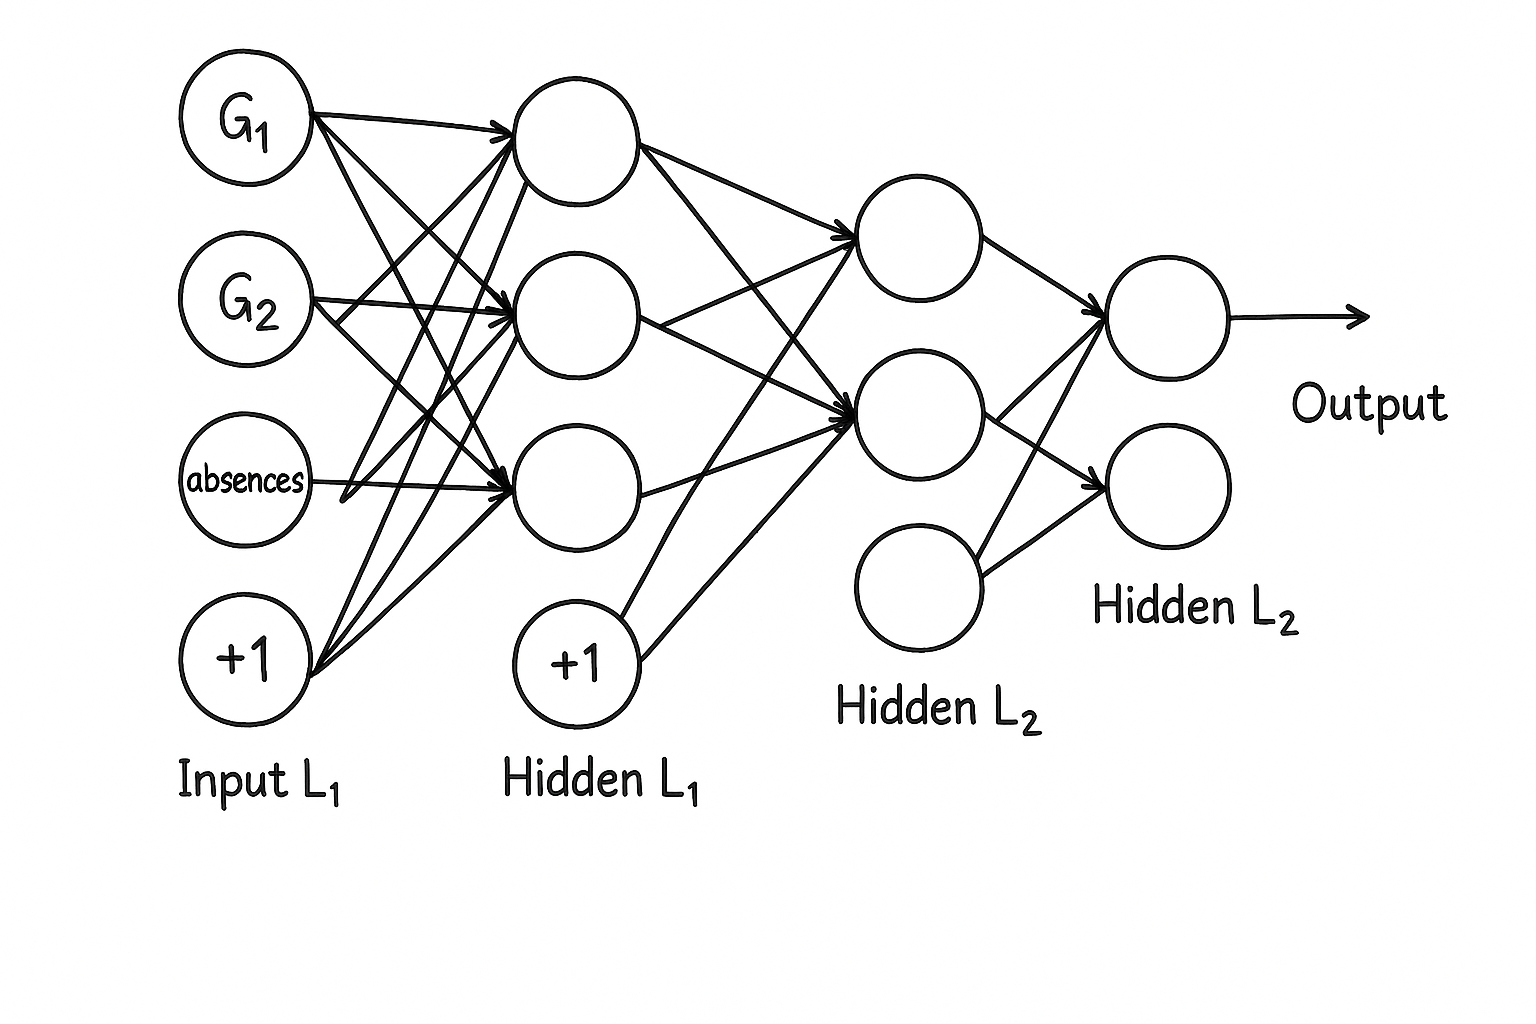



#Task: Define a function that creates models without and With specified Optimization techniques


In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

def define_model(optimization=None, regularizer=None, early_stopping=False, dropout_rate=0.0, learning_rate=0.001, layers_config=[16, 8]):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    for units in layers_config:
        model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizer))
        if dropout_rate:
            model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=learning_rate) if optimization == 'Adam' else RMSprop(learning_rate=learning_rate) if optimization == 'RMSprop' else 'adam'
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=10)] if early_stopping else []
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=callbacks, verbose=0)
    return model, history

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
def loss_curve_plot(history):
    if 'loss' not in history.history or 'val_loss' not in history.history:
        print("No loss data available to plot. Check if model trained sufficiently.")
        return
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_and_plot(model, history, name):
    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype(int)
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Loss': log_loss(y_test, y_prob)
    }
    print(f"{name} Metrics:", metrics)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    loss_curve_plot(history)

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Instance 1 Metrics: {'Accuracy': 0.9166666666666666, 'Precision': 0.8181818181818182, 'Recall': 0.9473684210526315, 'F1 Score': 0.8780487804878049, 'ROC AUC': np.float64(0.982028241335045), 'Loss': 0.1699016736690112}


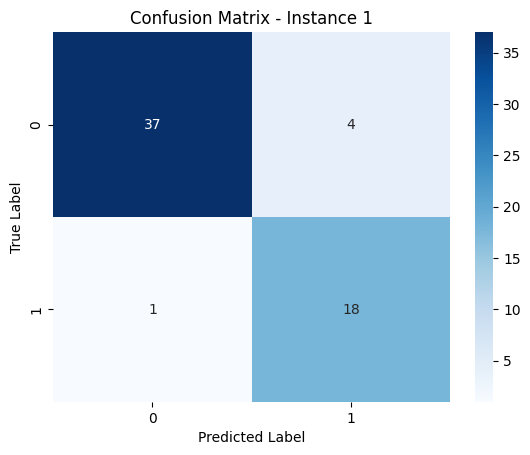

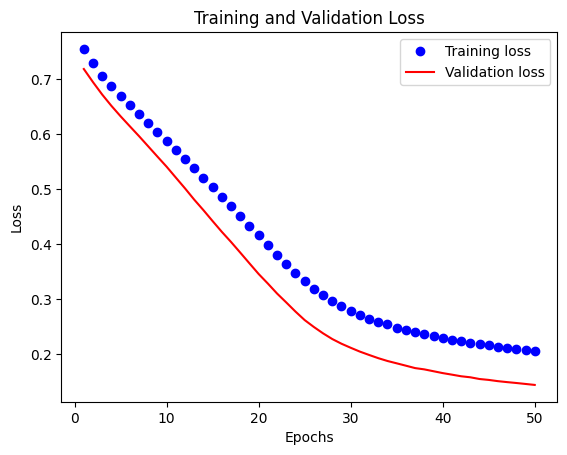

In [ ]:
model_1, history_1 = define_model()
model_1.save("saved_models/nn_instance1.keras")
evaluate_and_plot(model_1, history_1, "Instance 1")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Instance 2 Metrics: {'Accuracy': 0.9, 'Precision': 0.8095238095238095, 'Recall': 0.8947368421052632, 'F1 Score': 0.85, 'ROC AUC': np.float64(0.975609756097561), 'Loss': 0.18936010913359463}


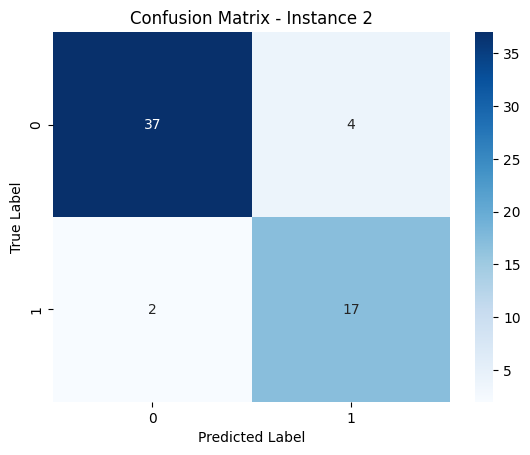

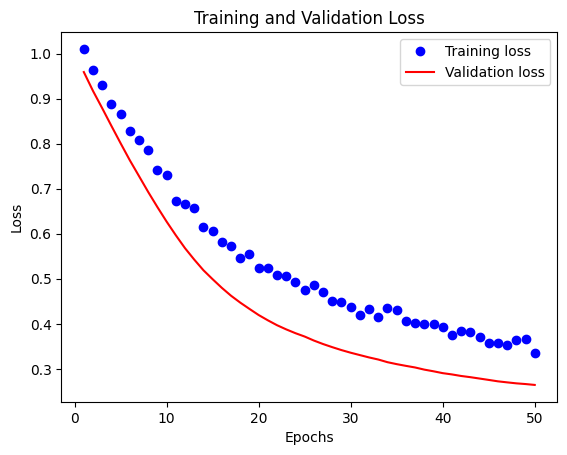

In [ ]:
model_2, history_2 = define_model('Adam', regularizers.l2(0.01), True, dropout_rate=0.3, learning_rate=0.001, layers_config=[32, 16])
model_2.save("saved_models/nn_instance2.keras")
evaluate_and_plot(model_2, history_2, "Instance 2")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Instance 3 Metrics: {'Accuracy': 0.9, 'Precision': 0.8095238095238095, 'Recall': 0.8947368421052632, 'F1 Score': 0.85, 'ROC AUC': np.float64(0.9743260590500642), 'Loss': 0.19107460047852462}


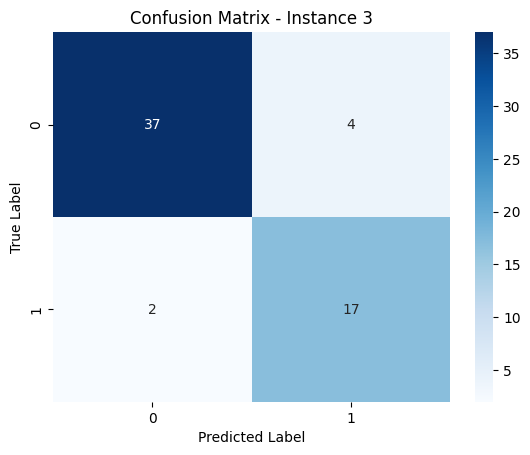

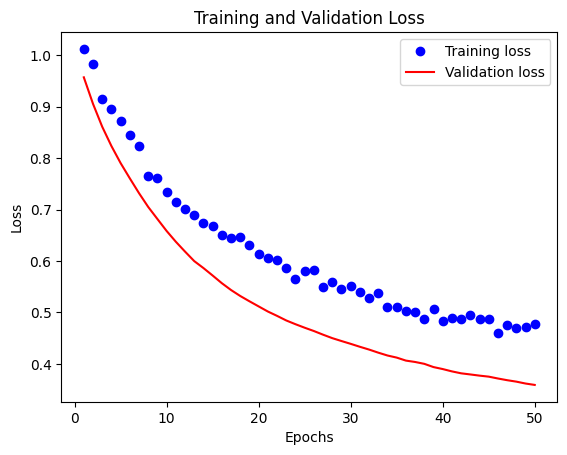

In [ ]:
model_3, history_3 = define_model('RMSprop', regularizers.l1(0.001), False, dropout_rate=0.4, learning_rate=0.0005, layers_config=[64, 32])
model_3.save("saved_models/nn_instance3.keras")
evaluate_and_plot(model_3, history_3, "Instance 3")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Instance 4 Metrics: {'Accuracy': 0.9166666666666666, 'Precision': 0.8181818181818182, 'Recall': 0.9473684210526315, 'F1 Score': 0.8780487804878049, 'ROC AUC': np.float64(0.9807445442875482), 'Loss': 0.17126622039615824}


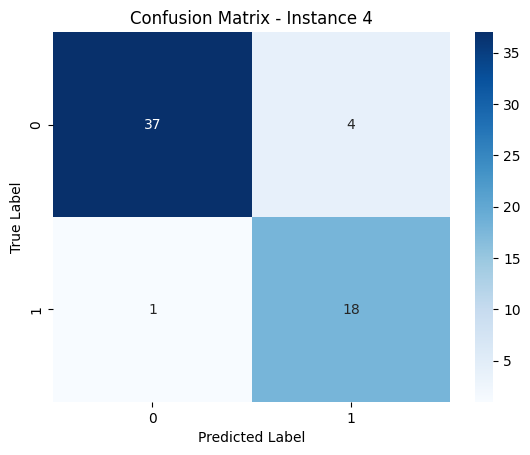

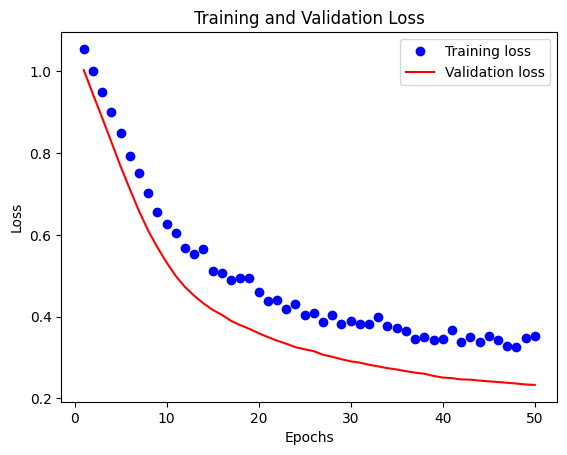

In [ ]:
model_4, history_4 = define_model('Adamax', regularizers.l2(0.005), True, dropout_rate=0.2, learning_rate=0.002, layers_config=[64, 32, 16])
model_4.save("saved_models/nn_instance4.keras")
evaluate_and_plot(model_4, history_4, "Instance 4")

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def make_predictions(model_path, X):
    model = tf.keras.models.load_model(model_path)
    predictions = (model.predict(X) > 0.5).astype(int)
    return predictions

# Load best model (e.g., Instance 4 based on metrics)
model_path = "saved_models/nn_instance4.keras"
predictions = make_predictions(model_path, X_test)
print("Sample Predictions:", predictions[:5])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Sample Predictions: [[1]
 [0]
 [1]
 [1]
 [1]]


Congratulations!!
